In [1]:
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import cv2
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import euclidean_distances

In [2]:
working_dir = os.getcwd()
print(f"You are now working in {working_dir}")
print("If you need to change to the parent directory, run the cell below")

You are now working in c:\Users\fredd\Desktop\Studier\Project5\flowers\flowers_CNN\jupyter_notebooks
If you need to change to the parent directory, run the cell below


In [3]:
os.chdir(os.path.dirname(working_dir))

new_working_dir = os.getcwd()
print(f"You have now changed your working directory to {new_working_dir}")

You have now changed your working directory to c:\Users\fredd\Desktop\Studier\Project5\flowers\flowers_CNN


In [8]:
version = 'v4'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(working_dir) and version in os.listdir(working_dir + '/outputs'):
    print("This version already exists, create a new version if you are working on a new version")
    pass
else:
    os.makedirs(name=file_path, exist_ok=True)

<hr>

### Search for non-image files


In [ ]:
"""
This function will search through the raw dataset
for files that doesn´t have the extensions
that we typed in at 'image_extension'.

When going through all the files the arrays for
image_files and non_image_files are filled with
result that in the end will be printed out.    
"""


def search_non_image_files(raw_dir):
    
    image_extension = ('.png', '.jpg', '.jpeg') # file extensions to search for
    
    non_image_files = [] # array for files without the extension searched for
    image_files = [] # array for image files with the extension searched for
    
    folders = os.listdir(raw_dir)
    for folder in folders:
        files = os.listdir(os.path.join(raw_dir, folder))
        
        for file in files: 
            file_location = os.path.join(raw_dir, folder, file)
            if not file.lower().endswith(image_extension):
                non_image_files.append(file_location)
            else:
                image_files.append(file_location)
    

    print("Total amount of folders searched:", len(folders))
    print("Total image files found:", len(image_files))
    print("Total non image files found:", len(non_image_files))
    
    return image_files, non_image_files

In [ ]:
search_non_image_files(raw_dir='inputs/dataset/raw/flower_photos')

### Split into train/validation/test sets

In [ ]:
import shutil
import random


def split_train_validation_test_images(image_dir, train_set_ratio, validation_set_ratio, test_set_ratio):
    
    # Check if the ratios are set to the correct total amount
    if train_set_ratio + validation_set_ratio + test_set_ratio != 1.0:
        print("The total of train_set_ratio, validation_set_ratio and test_set_ratio should be 1.0")
        return

    flowers = os.listdir(image_dir)
    
    # Creates train, validation and test folders if they don´t exist
    for folder in ['train', 'validation', 'test']:
        folder_path = os.path.join(image_dir, folder)
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        for flower in flowers:
            flower_folder_path = os.path.join(folder_path, flower)
            os.makedirs(flower_folder_path, exist_ok=True)

    # Moves images to the right sub-folder
    for flower in flowers:
        files = os.listdir(os.path.join(image_dir, flower))
        random.shuffle(files)

        train_set_files_qty = int(len(files) * train_set_ratio)
        validation_set_files_qty = int(len(files) * validation_set_ratio)

        count = 1
        for image_name in files:
            src_path = os.path.join(image_dir, flower, image_name)
            if count <= train_set_files_qty:
                dest_path = os.path.join(image_dir, 'train', flower, image_name)
            elif count <= (train_set_files_qty + validation_set_files_qty):
                dest_path = os.path.join(image_dir, 'validation', flower, image_name)
            else:
                dest_path = os.path.join(image_dir, 'test', flower, image_name)
            
            shutil.move(src_path, dest_path)
            count += 1

        # Deletes the inputfolder if it´s empty
        os.rmdir(os.path.join(image_dir, flower))

In [ ]:
split_train_validation_test_images(image_dir=f"inputs/dataset/raw/flower_photos",
                                   train_set_ratio=0.7,
                                   validation_set_ratio=0.1,
                                   test_set_ratio=0.2
                                   )

In [5]:
labels = os.listdir("inputs/dataset/raw/flower_photos/train")

print(f"Flower labels: {labels}")

Flower labels: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


* train - daisy: 3544 images
* train - dandelion: 5028 images
* train - roses: 3589 images
* train - sunflowers: 3914 images
* train - tulips: 4474 images
* validation - daisy: 506 images
* validation - dandelion: 718 images
* validation - roses: 512 images
* validation - sunflowers: 559 images
* validation - tulips: 639 images
* test - daisy: 1014 images
* test - dandelion: 1438 images
* test - roses: 1027 images
* test - sunflowers: 1119 images
* test - tulips: 1279 images




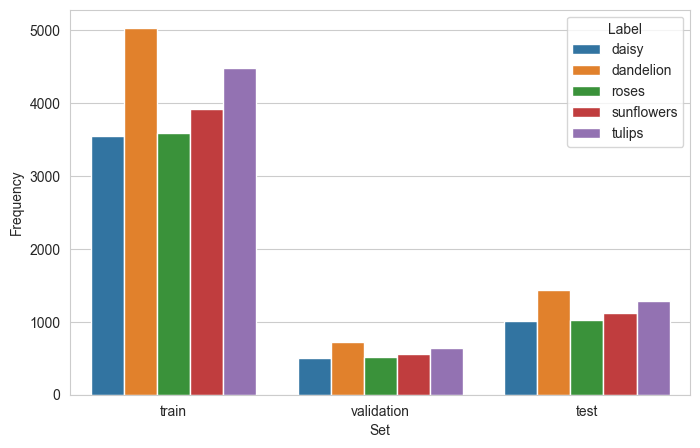

In [9]:
image_dirs = 'inputs/dataset/raw/flower_photos'

data = []


for folder in ['train', 'validation', 'test']:
    for label in labels:
        
        data.append({
            'Set': folder,
            'Label': label,
            'Frequency': int(len(os.listdir(image_dirs + '/' + folder + '/' + label)))
        })
        
        print(f"* {folder} - {label}: {len(os.listdir(image_dirs + '/' + folder + '/' + label))} images")


df_freq = pd.DataFrame(data)


print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png', bbox_inches='tight', dpi=150)
plt.show()

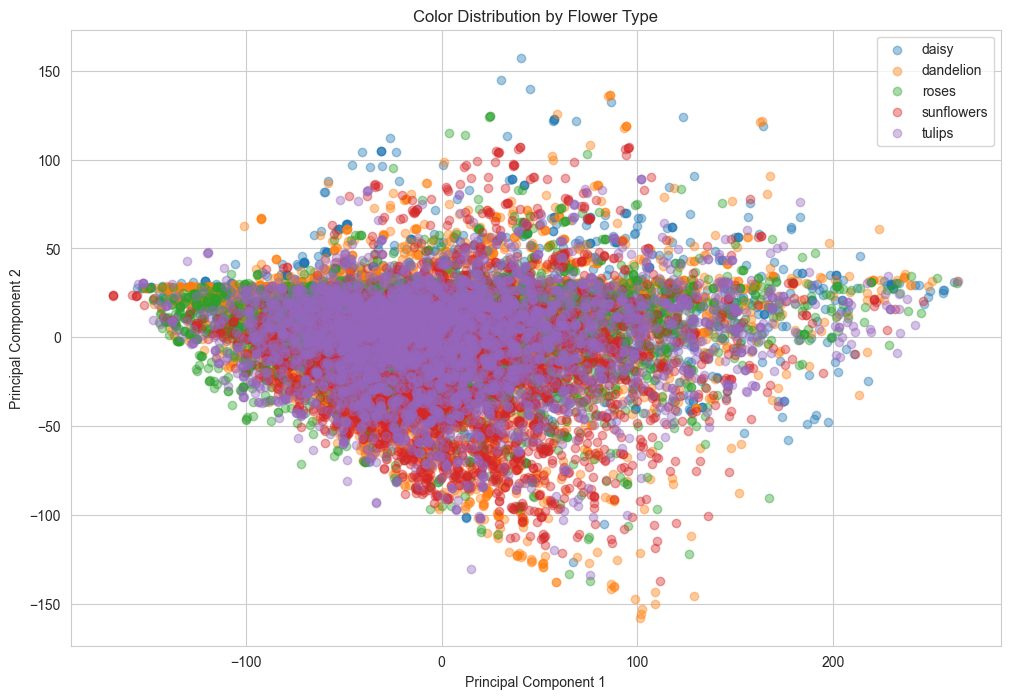

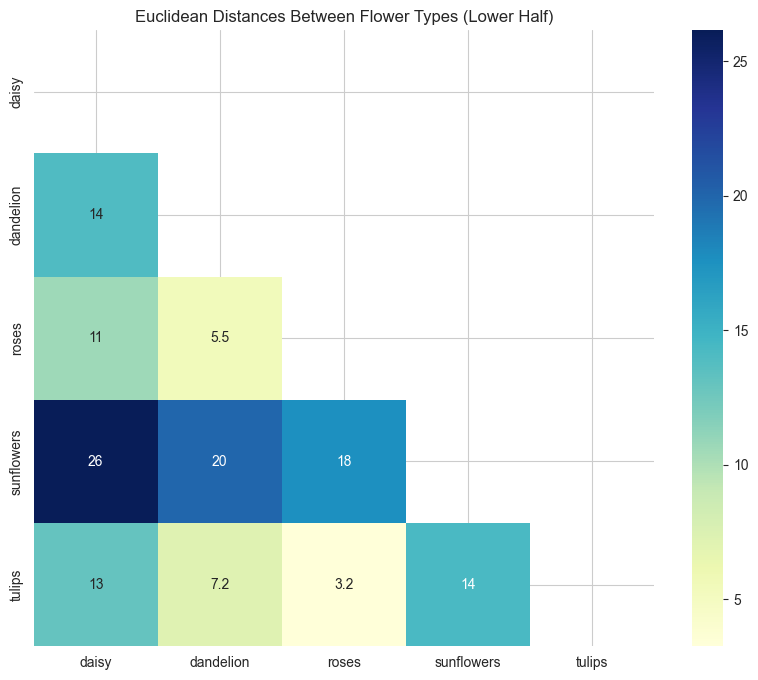

In [10]:
image_dirs = ['inputs/dataset/raw/flower_photos/train']

flower_paths = {}

# Iterates through all subfolders in train folder
for dir_path in image_dirs:
    for folder in os.listdir(dir_path):
        folder_path = os.path.join(dir_path, folder)
        if os.path.isdir(folder_path):
            if folder in flower_paths:
                flower_paths[folder].extend(glob.glob(os.path.join(folder_path, "*.jpg")))
            else:
                flower_paths[folder] = glob.glob(os.path.join(folder_path, "*.jpg"))

def color_pca_scatter_with_similarity(flower_paths):
    colors = []
    labels = []
    
    # gathers colors and labels
    for flower, paths in flower_paths.items():
        for path in paths:
            img = cv2.imread(path)
            if img is not None:
                avg_color = img.mean(axis=(0, 1))  
                colors.append(avg_color)
                labels.append(flower)
    
    # converts to PCA to reduce dimensions
    pca = PCA(n_components=2)
    colors_pca = pca.fit_transform(colors)
    colors_df = pd.DataFrame(colors_pca, columns=["PC1", "PC2"])
    colors_df['flower'] = labels
    
    # Creates scatterplot
    plt.figure(figsize=(12, 8))
    for flower in colors_df['flower'].unique():
        subset = colors_df[colors_df['flower'] == flower]
        plt.scatter(subset['PC1'], subset['PC2'], label=flower, alpha=0.4)
    plt.legend()
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.title("Color Distribution by Flower Type")
    
    # Saves the scatterplot
    plt.savefig(f'{file_path}/color_distribution_by_flower_type.png', dpi=300)
    plt.show()  
    
    # Calculates the mean value for PC1 and PC2 
    mean_pc = colors_df.groupby('flower')[['PC1', 'PC2']].mean()
    
    # Calculates the similarity (distance) between every flower category
    distance_matrix = euclidean_distances(mean_pc)
    
    # Deletes the upper half (mirror image)
    mask = np.triu(np.ones_like(distance_matrix, dtype=bool))  
    distance_matrix[mask] = np.nan  
    
    # Creates a heatmap over the similarities
    plt.figure(figsize=(10, 8))
    sns.heatmap(distance_matrix, annot=True, cmap='YlGnBu', xticklabels=mean_pc.index, yticklabels=mean_pc.index, mask=mask)
    plt.title("Euclidean Distances Between Flower Types (Lower Half)")
    
    # Saves the heatmap
    plt.savefig(f'{file_path}/flower_similarity_heatmap.png', dpi=300)
    plt.show()  


color_pca_scatter_with_similarity(flower_paths)